In [1]:
import mujoco
import mujoco.viewer
import numpy as np
import time
import matplotlib.pyplot as plt
import mediapy as media
from tqdm import tqdm
import scipy.linalg

## Load the model and Define the camera position for visualization

In [2]:
# Make new camera, set distance.
dt = 0.01

xml_path = "./cartpole.xml"
mj_model = mujoco.MjModel.from_xml_path(xml_path)
mj_data = mujoco.MjData(mj_model)
mj_model.opt.timestep = dt

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(mj_model, camera)
camera.distance = 4.0

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(mj_model, width=1280, height=720)


In [3]:
nu = mj_model.nu
nv = mj_model.nv

In [4]:
# Set the initial state and control.
qpos0 = np.zeros((2,))
ctrl0 = np.array([0]) 
mujoco.mj_resetData(mj_model, mj_data)
mj_data.ctrl = ctrl0
mj_data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(mj_model, mj_data, epsilon, flg_centered, A, B, None, None)

## Define the Q and R matrices 

In [5]:
R = np.eye(nu)
Q = np.eye(2*nv)

# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

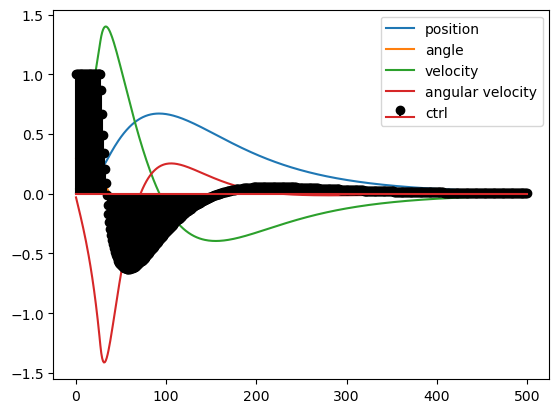

In [6]:
# Parameters.
DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(mj_model, mj_data)
mj_data.qpos = np.array([0, 0.3])

# Allocate position difference dq.
dq = np.zeros(mj_model.nv)

frames = []
ctrl_log = []
state_log = []
while mj_data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(mj_model, dq, 1, qpos0, mj_data.qpos)
  dx = np.hstack((dq, mj_data.qvel)).T

  # LQR control law.
  mj_data.ctrl = np.clip(ctrl0 - K @ dx, -1, 1)
  ctrl_log.append(np.clip(ctrl0 - K @ dx,-1,1))

  # Step the simulation.
  mujoco.mj_step(mj_model, mj_data)
  state_log.append(np.concatenate((mj_data.qpos, mj_data.qvel),axis=0))

  # Render and save frames.
  if len(frames) < mj_data.time * FRAMERATE:
    renderer.update_scene(mj_data)
    pixels = renderer.render()
    frames.append(pixels)
z = np.stack(state_log)
v = np.stack(ctrl_log)
plt.plot(z)
plt.stem(v, 'k')
plt.legend(['position','angle','velocity','angular velocity','ctrl'])
plt.savefig("LQR_cartpole")


In [7]:
media.write_video('LQR_cartpole.mp4', frames, fps=FRAMERATE)
media.show_video(media.read_video('LQR_cartpole.mp4'), fps=FRAMERATE)